In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,precision_score
from sklearn.metrics import roc_curve, roc_auc_score,auc, confusion_matrix
import xgboost as xgb

In [2]:
data_test=pd.read_csv("data/test.csv")
data_train=pd.read_csv("data/train.csv")

In [3]:
X_test = data_test.copy()

In [4]:
data_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15713774.0,Hsieh,683.0,Germany,Male,49.0,7.0,123837.86,2.0,1.0,1.0,138700.75,1.0
1,1,15682533.0,Hs?eh,608.0,France,Female,30.0,10.0,0.00,2.0,1.0,1.0,146723.72,0.0
2,2,15791550.0,Tsou,539.0,France,Female,32.0,8.0,0.00,1.0,1.0,1.0,94873.60,0.0
3,3,15762762.0,Chiawuotu,530.0,Spain,Female,39.0,8.0,0.00,2.0,0.0,0.0,177896.93,0.0
4,4,15756475.0,Nnamdi,613.0,France,Female,45.0,10.0,0.00,2.0,1.0,1.0,116748.14,0.0


In [5]:
data_train.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [6]:
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard','IsActiveMember', 'EstimatedSalary', 'Exited']

In [7]:
#Enlever les variables qui ne sont pas nécessaires
data_train = data_train.drop(columns=["id","CustomerId", "Surname"])


In [8]:
X_test = X_test.drop(columns=["id","CustomerId", "Surname"])

# Correlation

# Doublons

# NA

Nous divisons notre base de données en ensembles d'entraînement (train) et de test avant de réaliser toutes les manipulations, afin d'éviter de biaiser les résultats sur l'ensemble de test.
(page 274 cours ML: Model Selection (hold out a validation set))

In [9]:
train_selection, val_selection = train_test_split(data_train, test_size=0.2, random_state=0, stratify=data_train['Exited'])

In [10]:
# suppression des valeurs aberrantes pour CreditScore
train_selection = train_selection[train_selection['CreditScore'] <= 1000]

# Feature Engineering


In [11]:
# Encodez les variables catégorielles en utilisant One-Hot Encoding
categorical_columns = [col for col in ['Geography', 'Gender'] if col in train_selection.columns]
train_selection = pd.get_dummies(train_selection, columns=categorical_columns, drop_first=True)*1
categorical_columns = [col for col in ['Geography', 'Gender'] if col in val_selection.columns]
val_selection = pd.get_dummies(val_selection, columns=categorical_columns, drop_first=True)*1

categorical_columns = [col for col in ['Geography', 'Gender'] if col in X_test.columns]
X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)*1

In [12]:
# import pandas as pd
# import numpy as np
# from statsmodels.api import Logit, add_constant
# from sklearn.metrics import roc_auc_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import StratifiedKFold

# # Prepare features (X) and target (y)
# X = train_selection.drop(columns=['Exited'])
# y = train_selection['Exited']

# # Add a constant for logistic regression
# X = add_constant(X)

# # Fit a logistic regression model
# logit_model = Logit(y, X)
# result = logit_model.fit()

# # Calculate predicted probabilities
# y_pred = result.predict(X)

# # Calculate residuals manually
# residuals = y - y_pred

# # Calculate leverage
# influence = result.get_influence()
# leverage = influence.hat_matrix_diag

# # Manually compute standardized residuals
# sigma_squared = (residuals**2).mean()  # Approximation of variance
# standardized_residuals = residuals / np.sqrt(sigma_squared * (1 - leverage))

# # Add residuals and leverage to the dataset
# train_selection['Standardized_Residuals'] = standardized_residuals
# train_selection['Leverage'] = leverage

# # Define thresholds for outliers and influential points
# residual_threshold = 2  # Observations with residuals > 2 are flagged
# leverage_threshold = 2 * X.shape[1] / len(X)  # Leverage > 2 * (p/n)

# # Identify points that are both outliers and influential
# outliers_and_influential = train_selection[
#     (abs(train_selection['Standardized_Residuals']) > residual_threshold) &
#     (train_selection['Leverage'] > leverage_threshold)
# ]

# # Remove only points that are both outliers and influential
# data_cleaned = train_selection[~train_selection.index.isin(outliers_and_influential.index)]

# # Prepare the cleaned dataset
# X_cleaned = data_cleaned.drop(columns=['Exited', 'Standardized_Residuals', 'Leverage'])
# y_cleaned = data_cleaned['Exited']

# # Function to evaluate model using Stratified K-Fold
# def evaluate_with_stratified_kfold(X, y, n_splits=5):
#     """
#     Evaluate model using Stratified K-Fold and return the mean AUC score.
#     """
#     skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
#     auc_scores = []

#     for train_index, test_index in skf.split(X, y):
#         X_train_out, X_test_out = X.iloc[train_index], X.iloc[test_index]
#         y_train_out, y_test_out = y.iloc[train_index], y.iloc[test_index]

#         model = LogisticRegression(max_iter=1000, random_state=42)
#         model.fit(X_train_out, y_train_out)
#         y_pred = model.predict_proba(X_test_out)[:, 1]
#         auc = roc_auc_score(y_test_out, y_pred)
#         auc_scores.append(auc)

#     return np.mean(auc_scores)

# # Evaluate original dataset
# X_original = train_selection.drop(columns=['Exited', 'Standardized_Residuals', 'Leverage'])
# y_original = train_selection['Exited']
# auc_original = evaluate_with_stratified_kfold(X_original, y_original)

# # Evaluate cleaned dataset
# auc_cleaned = evaluate_with_stratified_kfold(X_cleaned, y_cleaned)

# # Compare the results
# print(f"Number of points that are both outliers and influential: {len(outliers_and_influential)}")
# print(f"AUC Score with Original Data: {auc_original:.4f}")
# print(f"AUC Score with Cleaned Data (Points Removed): {auc_cleaned:.4f}")

# # Decision based on improvement
# if auc_cleaned > auc_original:
#     print("Removing points that are both outliers and influential improved the AUC score.")
# else:
#     print("Removing points that are both outliers and influential did not improve the AUC score.")


In [13]:
# Remove the identified outliers from the dataset
#data_train_cleaned = train_selection[~train_selection.index.isin(outliers_and_influential.index)]

# Confirm the outliers are removed
#data_train_cleaned.reset_index(drop=True, inplace=True)

#train_selection = data_train_cleaned.copy()

In [14]:
train_selection.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')

In [15]:
#X_train = train_selection.drop(columns=['Exited', 'Leverage', 'Standardized_Residuals'])   # Toutes les colonnes sauf 'Exited' pour les variables explicatives
X_train = train_selection.drop(columns=['Exited'])
y_train = train_selection['Exited']                 # Cible (1 = churn, 0 = non-churn)

X_val = val_selection.drop(columns=['Exited'])  # Toutes les colonnes sauf 'Exited' pour les variables explicatives
y_val = val_selection['Exited']                 # Cible (1 = churn, 0 = non-churn)

In [16]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

# Train a LightGBM model
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display feature importances
print(feature_importances)

# Select top features (e.g., top 10)
top_features = feature_importances['Feature'].iloc[:10].values
X_train_selected = X_train[top_features]



[LightGBM] [Info] Number of positive: 2392, number of negative: 9607
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 845
[LightGBM] [Info] Number of data points in the train set: 11999, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199350 -> initscore=-1.390362
[LightGBM] [Info] Start training from score -1.390362
              Feature  Importance
0         CreditScore         607
7     EstimatedSalary         571
1                 Age         510
3             Balance         477
2              Tenure         235
4       NumOfProducts         202
6      IsActiveMember         128
10        Gender_Male         110
8   Geography_Germany         106
9     Geography_Spain          28
5           HasCrCard          26


In [17]:
X_train.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')

In [18]:
X_train_after_selection = X_train.drop(columns=['HasCrCard','Geography_Spain'])
X_val_after_selection = X_val.drop(columns=['HasCrCard','Geography_Spain'])
X_test = X_test.drop(columns=['HasCrCard','Geography_Spain'])

#X_test = X_test.drop(columns=['HasCrCard','IsActive_by_CreditCard', 'Customer_Status', 'Geography_Spain',
                                                #'Account_Balance_Zero Balance', 'CreditScoreTier'])

In [19]:
categorical_features = ['IsActiveMember', 'Geography_Germany', 'Gender_Male']

for col in categorical_features:
    X_train_after_selection[col] = X_train_after_selection[col].astype('str')
    X_val_after_selection[col] = X_val_after_selection[col].astype('str')
    X_test[col] = X_test[col].astype('str')

In [20]:
  d

NameError: name 'd' is not defined

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Define parameters
param_grid = {
    'depth': [4, 6, 8],              # Tree depths to try
    'learning_rate': [0.01, 0.1, 0.2], # Learning rates to test
    'iterations': [100, 200, 500]      # Number of boosting iterations
}

# Create StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


model = CatBoostClassifier( random_state=42, verbose=0)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',  # Use accuracy for classification tasks
    cv=skf,
    verbose=2                 
)

# Fit the model
grid_search.fit(X_train_after_selection, y_train)

# Extract and print AUC scores for each trial
results = grid_search.cv_results_
mean_auc_scores = results['mean_test_score']
param_combinations = results['params']

for params, mean_auc in zip(param_combinations, mean_auc_scores):
    print(f"Params: {params}, Mean AUC: {mean_auc:.4f}")

# Output best parameters
best_params1 = grid_search.best_params_
print("Best params:", best_params1)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   0.3s
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   0.4s
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   0.3s
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   0.4s
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   0.4s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=   0.4s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=   0.3s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=   0.3s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=   0.3s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=   0.3s
[CV] END .........depth=4, iterations=100, learning_rate=0.2; total time=   0.2s
[CV] END .........depth=4, iterations=100, lear

Fold 1: Train AUC = 0.9467, Validation AUC = 0.9285
Fold 2: Train AUC = 0.9472, Validation AUC = 0.9277
Fold 3: Train AUC = 0.9426, Validation AUC = 0.9498
Fold 4: Train AUC = 0.9430, Validation AUC = 0.9484
Fold 5: Train AUC = 0.9462, Validation AUC = 0.9310

Mean Train AUC: 0.9451
Mean Validation AUC: 0.9371
Validation AUC Standard Deviation: 0.0099


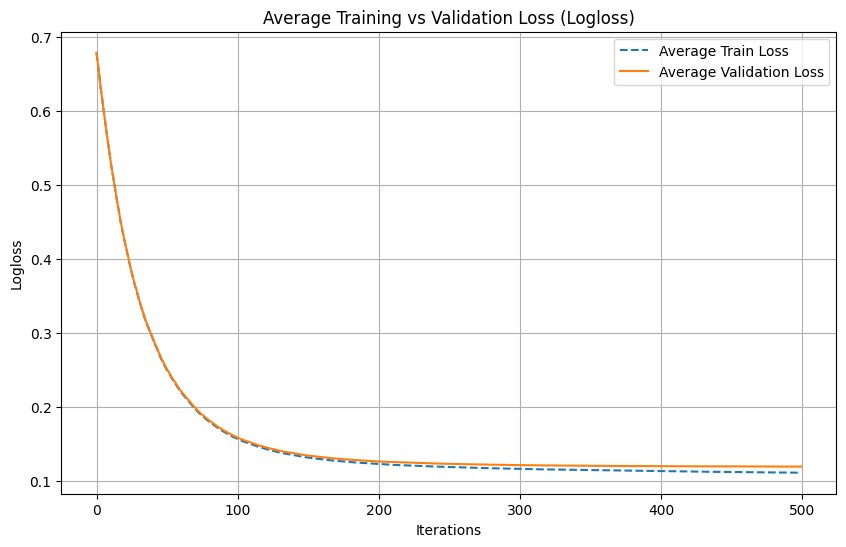

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import numpy as np

# Initialize Stratified K-Fold
n_splits = 5  # Number of folds for cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

# Initialize lists to store fold results
train_auc_scores = []
val_auc_scores = []
train_losses = []
val_losses = []

params = {
    'depth': 6, 'iterations': 500, 'learning_rate': 0.01,
    'scale_pos_weight': 0.25, 
    'verbose': 0,
    'cat_features': categorical_features
}

# Train and validate using Stratified K-Fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_after_selection, y_train)):
    # Split the small train set into folds
    X_train_fold, X_val_fold = X_train_after_selection.iloc[train_idx], X_train_after_selection.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Initialize CatBoost model
    model = CatBoostClassifier(**params)

    # Train on current fold
    model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), early_stopping_rounds=50, verbose=0)

    # Extract loss for plotting
    eval_results = model.get_evals_result()
    train_losses.append(eval_results['learn']['Logloss'])
    val_losses.append(eval_results['validation']['Logloss'])

    # Predict probabilities for training and validation folds
    y_train_pred = model.predict_proba(X_train_fold)[:, 1]
    y_val_pred = model.predict_proba(X_val_fold)[:, 1]

    # Calculate ROC AUC for training and validation folds
    train_auc = roc_auc_score(y_train_fold, y_train_pred)
    val_auc = roc_auc_score(y_val_fold, y_val_pred)

    train_auc_scores.append(train_auc)
    val_auc_scores.append(val_auc)

    print(f"Fold {fold + 1}: Train AUC = {train_auc:.4f}, Validation AUC = {val_auc:.4f}")

# Print Cross-Validation Results
mean_train_auc = np.mean(train_auc_scores)
mean_val_auc = np.mean(val_auc_scores)
std_val_auc = np.std(val_auc_scores)

print(f"\nMean Train AUC: {mean_train_auc:.4f}")
print(f"Mean Validation AUC: {mean_val_auc:.4f}")
print(f"Validation AUC Standard Deviation: {std_val_auc:.4f}")

# Calculate average losses across folds
max_iterations = min(len(train_losses[fold]) for fold in range(n_splits))  # Ensure consistent length
avg_train_loss = np.mean([train_losses[fold][:max_iterations] for fold in range(n_splits)], axis=0)
avg_val_loss = np.mean([val_losses[fold][:max_iterations] for fold in range(n_splits)], axis=0)

# Plot Average Loss Graph
plt.figure(figsize=(10, 6))
plt.plot(range(max_iterations), avg_train_loss, label='Average Train Loss', linestyle='--')
plt.plot(range(max_iterations), avg_val_loss, label='Average Validation Loss')
plt.title('Average Training vs Validation Loss (Logloss)')
plt.xlabel('Iterations')
plt.ylabel('Logloss')
plt.legend()
plt.grid(True)
plt.show()


In [69]:
# Train final model on the entire small train set
final_model = CatBoostClassifier(
   **params
)
final_model.fit(X_train_after_selection, y_train, eval_set=(X_val_after_selection, y_val), early_stopping_rounds=50, verbose=0)

# Evaluate on validation set
y_val_pred = final_model.predict_proba(X_val_after_selection)[:, 1]
final_roc_auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation ROC AUC on Hold-out Set: {final_roc_auc:.4f}")

Validation ROC AUC on Hold-out Set: 0.9301


In [75]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from catboost import CatBoostClassifier

# Define parameter grid for Grid Search
param_grid = {
    'depth': [6, 8],
    'iterations': [1000, 1500],
    'learning_rate': [0.005, 0.01],
    'l2_leaf_reg': [3, 5],
    'bagging_temperature': [0.8, 1.0],
}

# Initialize Stratified K-Fold
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize CatBoost model
catboost_model = CatBoostClassifier(cat_features=categorical_features, random_seed=42, verbose=0)

# Grid Search with Stratified K-Fold
grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=skf,
    verbose=1,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train_after_selection, y_train)

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best ROC AUC Score from Grid Search: {best_score}")


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'bagging_temperature': 0.8, 'depth': 6, 'iterations': 1500, 'l2_leaf_reg': 3, 'learning_rate': 0.005}
Best ROC AUC Score from Grid Search: 0.9386525466743352


Fold 1: Train AUC = 0.9505, Validation AUC = 0.9294
Fold 2: Train AUC = 0.9527, Validation AUC = 0.9282
Fold 3: Train AUC = 0.9492, Validation AUC = 0.9505
Fold 4: Train AUC = 0.9498, Validation AUC = 0.9476
Fold 5: Train AUC = 0.9515, Validation AUC = 0.9321

Mean Train AUC: 0.9507
Mean Validation AUC: 0.9376
Validation AUC Standard Deviation: 0.0095


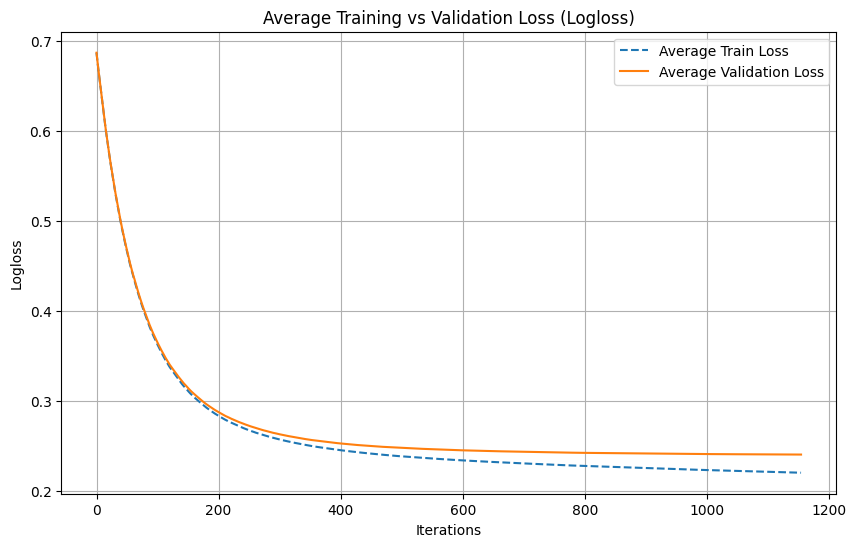

In [84]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import numpy as np

# Initialize Stratified K-Fold
n_splits = 5  # Number of folds for cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

# Initialize lists to store fold results
train_auc_scores = []
val_auc_scores = []
train_losses = []
val_losses = []

params = {
    'bagging_temperature': 0.8, 'depth': 6, 'iterations': 1500, 'l2_leaf_reg': 3, 'learning_rate': 0.005,
    'verbose': 0,
    'cat_features': categorical_features
}

# Train and validate using Stratified K-Fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_after_selection, y_train)):
    # Split the small train set into folds
    X_train_fold, X_val_fold = X_train_after_selection.iloc[train_idx], X_train_after_selection.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Initialize CatBoost model
    model = CatBoostClassifier(**params)

    # Train on current fold
    model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), early_stopping_rounds=50, verbose=0)

    # Extract loss for plotting
    eval_results = model.get_evals_result()
    train_losses.append(eval_results['learn']['Logloss'])
    val_losses.append(eval_results['validation']['Logloss'])

    # Predict probabilities for training and validation folds
    y_train_pred = model.predict_proba(X_train_fold)[:, 1]
    y_val_pred = model.predict_proba(X_val_fold)[:, 1]

    # Calculate ROC AUC for training and validation folds
    train_auc = roc_auc_score(y_train_fold, y_train_pred)
    val_auc = roc_auc_score(y_val_fold, y_val_pred)

    train_auc_scores.append(train_auc)
    val_auc_scores.append(val_auc)

    print(f"Fold {fold + 1}: Train AUC = {train_auc:.4f}, Validation AUC = {val_auc:.4f}")

# Print Cross-Validation Results
mean_train_auc = np.mean(train_auc_scores)
mean_val_auc = np.mean(val_auc_scores)
std_val_auc = np.std(val_auc_scores)

print(f"\nMean Train AUC: {mean_train_auc:.4f}")
print(f"Mean Validation AUC: {mean_val_auc:.4f}")
print(f"Validation AUC Standard Deviation: {std_val_auc:.4f}")

# Calculate average losses across folds
max_iterations = min(len(train_losses[fold]) for fold in range(n_splits))  # Ensure consistent length
avg_train_loss = np.mean([train_losses[fold][:max_iterations] for fold in range(n_splits)], axis=0)
avg_val_loss = np.mean([val_losses[fold][:max_iterations] for fold in range(n_splits)], axis=0)

# Plot Average Loss Graph
plt.figure(figsize=(10, 6))
plt.plot(range(max_iterations), avg_train_loss, label='Average Train Loss', linestyle='--')
plt.plot(range(max_iterations), avg_val_loss, label='Average Validation Loss')
plt.title('Average Training vs Validation Loss (Logloss)')
plt.xlabel('Iterations')
plt.ylabel('Logloss')
plt.legend()
plt.grid(True)
plt.show()


In [85]:
# Train final model on the entire small train set
final_model = CatBoostClassifier(
   **params
)
final_model.fit(X_train_after_selection, y_train, eval_set=(X_val_after_selection, y_val), early_stopping_rounds=50, verbose=0)

# Evaluate on validation set
y_val_pred = final_model.predict_proba(X_val_after_selection)[:, 1]
final_roc_auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation ROC AUC on Hold-out Set: {final_roc_auc:.4f}")

#Score on kaggle: 0.9313 (proche)

Validation ROC AUC on Hold-out Set: 0.9315


In [86]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from catboost import CatBoostClassifier

# Define parameter grid for Grid Search
param_grid = {
    'depth': [5, 6, 7],
    'iterations': [1500, 2000, 2500],
    'learning_rate': [0.0025, 0.005, 0.0075],
    'l2_leaf_reg': [2, 3, 4],
    'bagging_temperature': [0.7, 0.8, 0.9],
}

# Initialize Stratified K-Fold
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize CatBoost model
catboost_model = CatBoostClassifier(cat_features=categorical_features, random_seed=42, verbose=0)

# Grid Search with Stratified K-Fold
grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=skf,
    verbose=1,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train_after_selection, y_train)

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best ROC AUC Score from Grid Search: {best_score}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'bagging_temperature': 0.7, 'depth': 5, 'iterations': 2000, 'l2_leaf_reg': 3, 'learning_rate': 0.005}
Best ROC AUC Score from Grid Search: 0.9388074048168124


Fold 1: Train AUC = 0.9495, Validation AUC = 0.9295
Fold 2: Train AUC = 0.9497, Validation AUC = 0.9285
Fold 3: Train AUC = 0.9472, Validation AUC = 0.9512
Fold 4: Train AUC = 0.9475, Validation AUC = 0.9485
Fold 5: Train AUC = 0.9493, Validation AUC = 0.9322

Mean Train AUC: 0.9486
Mean Validation AUC: 0.9380
Validation AUC Standard Deviation: 0.0098


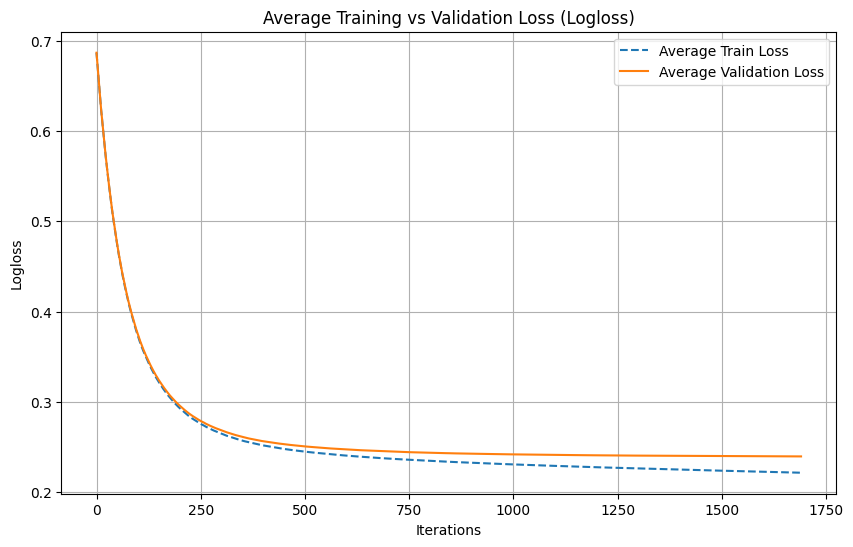

In [87]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import numpy as np

# Initialize Stratified K-Fold
n_splits = 5  # Number of folds for cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

# Initialize lists to store fold results
train_auc_scores = []
val_auc_scores = []
train_losses = []
val_losses = []

params = {
    'bagging_temperature': 0.7, 'depth': 5, 'iterations': 2000, 'l2_leaf_reg': 3, 'learning_rate': 0.005,
    'verbose': 0,
    'cat_features': categorical_features
}

# Train and validate using Stratified K-Fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_after_selection, y_train)):
    # Split the small train set into folds
    X_train_fold, X_val_fold = X_train_after_selection.iloc[train_idx], X_train_after_selection.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Initialize CatBoost model
    model = CatBoostClassifier(**params)

    # Train on current fold
    model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), early_stopping_rounds=50, verbose=0)

    # Extract loss for plotting
    eval_results = model.get_evals_result()
    train_losses.append(eval_results['learn']['Logloss'])
    val_losses.append(eval_results['validation']['Logloss'])

    # Predict probabilities for training and validation folds
    y_train_pred = model.predict_proba(X_train_fold)[:, 1]
    y_val_pred = model.predict_proba(X_val_fold)[:, 1]

    # Calculate ROC AUC for training and validation folds
    train_auc = roc_auc_score(y_train_fold, y_train_pred)
    val_auc = roc_auc_score(y_val_fold, y_val_pred)

    train_auc_scores.append(train_auc)
    val_auc_scores.append(val_auc)

    print(f"Fold {fold + 1}: Train AUC = {train_auc:.4f}, Validation AUC = {val_auc:.4f}")

# Print Cross-Validation Results
mean_train_auc = np.mean(train_auc_scores)
mean_val_auc = np.mean(val_auc_scores)
std_val_auc = np.std(val_auc_scores)

print(f"\nMean Train AUC: {mean_train_auc:.4f}")
print(f"Mean Validation AUC: {mean_val_auc:.4f}")
print(f"Validation AUC Standard Deviation: {std_val_auc:.4f}")

# Calculate average losses across folds
max_iterations = min(len(train_losses[fold]) for fold in range(n_splits))  # Ensure consistent length
avg_train_loss = np.mean([train_losses[fold][:max_iterations] for fold in range(n_splits)], axis=0)
avg_val_loss = np.mean([val_losses[fold][:max_iterations] for fold in range(n_splits)], axis=0)

# Plot Average Loss Graph
plt.figure(figsize=(10, 6))
plt.plot(range(max_iterations), avg_train_loss, label='Average Train Loss', linestyle='--')
plt.plot(range(max_iterations), avg_val_loss, label='Average Validation Loss')
plt.title('Average Training vs Validation Loss (Logloss)')
plt.xlabel('Iterations')
plt.ylabel('Logloss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Train final model on the entire small train set
final_model = CatBoostClassifier(
   **params
)
final_model.fit(X_train_after_selection, y_train, eval_set=(X_val_after_selection, y_val), early_stopping_rounds=50, verbose=0)

# Evaluate on validation set
y_val_pred = final_model.predict_proba(X_val_after_selection)[:, 1]
final_roc_auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation ROC AUC on Hold-out Set: {final_roc_auc:.4f}")
#0.9312: baisse => trop complique


Validation ROC AUC on Hold-out Set: 0.9318


Fold 1: Train AUC = 0.9484, Validation AUC = 0.9296
Fold 2: Train AUC = 0.9483, Validation AUC = 0.9288
Fold 3: Train AUC = 0.9445, Validation AUC = 0.9506
Fold 4: Train AUC = 0.9449, Validation AUC = 0.9482
Fold 5: Train AUC = 0.9471, Validation AUC = 0.9321

Mean Train AUC: 0.9466
Mean Validation AUC: 0.9379
Validation AUC Standard Deviation: 0.0095


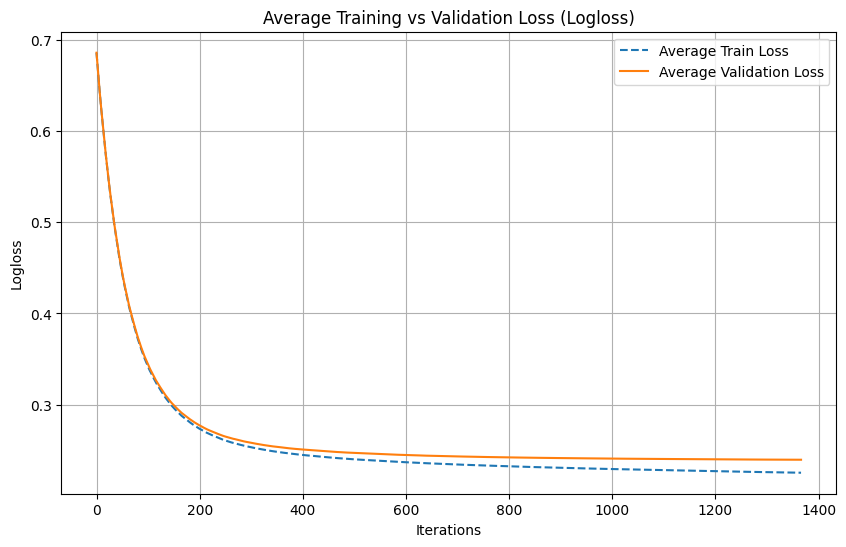

Validation ROC AUC on Hold-out Set: 0.9324


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import numpy as np

# Initialize Stratified K-Fold
n_splits = 5  # Number of folds for cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

# Initialize lists to store fold results
train_auc_scores = []
val_auc_scores = []
train_losses = []
val_losses = []

params = {
    'bagging_temperature': 0.8, 'depth': 6, 'iterations': 1700, 'l2_leaf_reg': 3, 'learning_rate': 0.006,
    'verbose': 0,
    'cat_features': categorical_features, 
    'subsample': 0.9, #added
    'random_strength': 1.0,  # Added
    'max_bin': 254,  # Added
    'min_data_in_leaf': 20,# Added
    'leaf_estimation_iterations': 5,  # Added
}

# Train and validate using Stratified K-Fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_after_selection, y_train)):
    # Split the small train set into folds
    X_train_fold, X_val_fold = X_train_after_selection.iloc[train_idx], X_train_after_selection.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Initialize CatBoost model
    model = CatBoostClassifier(**params)

    # Train on current fold
    model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), early_stopping_rounds=50, verbose=0)

    # Extract loss for plotting
    eval_results = model.get_evals_result()
    train_losses.append(eval_results['learn']['Logloss'])
    val_losses.append(eval_results['validation']['Logloss'])

    # Predict probabilities for training and validation folds
    y_train_pred = model.predict_proba(X_train_fold)[:, 1]
    y_val_pred = model.predict_proba(X_val_fold)[:, 1]

    # Calculate ROC AUC for training and validation folds
    train_auc = roc_auc_score(y_train_fold, y_train_pred)
    val_auc = roc_auc_score(y_val_fold, y_val_pred)

    train_auc_scores.append(train_auc)
    val_auc_scores.append(val_auc)

    print(f"Fold {fold + 1}: Train AUC = {train_auc:.4f}, Validation AUC = {val_auc:.4f}")

# Print Cross-Validation Results
mean_train_auc = np.mean(train_auc_scores)
mean_val_auc = np.mean(val_auc_scores)
std_val_auc = np.std(val_auc_scores)

print(f"\nMean Train AUC: {mean_train_auc:.4f}")
print(f"Mean Validation AUC: {mean_val_auc:.4f}")
print(f"Validation AUC Standard Deviation: {std_val_auc:.4f}")

# Calculate average losses across folds
max_iterations = min(len(train_losses[fold]) for fold in range(n_splits))  # Ensure consistent length
avg_train_loss = np.mean([train_losses[fold][:max_iterations] for fold in range(n_splits)], axis=0)
avg_val_loss = np.mean([val_losses[fold][:max_iterations] for fold in range(n_splits)], axis=0)

# Plot Average Loss Graph
plt.figure(figsize=(10, 6))
plt.plot(range(max_iterations), avg_train_loss, label='Average Train Loss', linestyle='--')
plt.plot(range(max_iterations), avg_val_loss, label='Average Validation Loss')
plt.title('Average Training vs Validation Loss (Logloss)')
plt.xlabel('Iterations')
plt.ylabel('Logloss')
plt.legend()
plt.grid(True)
plt.show()

# Train final model on the entire small train set
final_model = CatBoostClassifier(
   **params
)
final_model.fit(X_train_after_selection, y_train, eval_set=(X_val_after_selection, y_val), early_stopping_rounds=50, verbose=0)

# Evaluate on validation set
y_val_pred = final_model.predict_proba(X_val_after_selection)[:, 1]
final_roc_auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation ROC AUC on Hold-out Set: {final_roc_auc:.4f}")

#0.9316 sur kaggle donc assez proche still ok


Fold 1: Train AUC = 0.9484, Validation AUC = 0.9296
Fold 2: Train AUC = 0.9483, Validation AUC = 0.9288
Fold 3: Train AUC = 0.9445, Validation AUC = 0.9506
Fold 4: Train AUC = 0.9449, Validation AUC = 0.9482
Fold 5: Train AUC = 0.9471, Validation AUC = 0.9321

Mean Train AUC: 0.9466
Mean Validation AUC: 0.9379
Validation AUC Standard Deviation: 0.0095


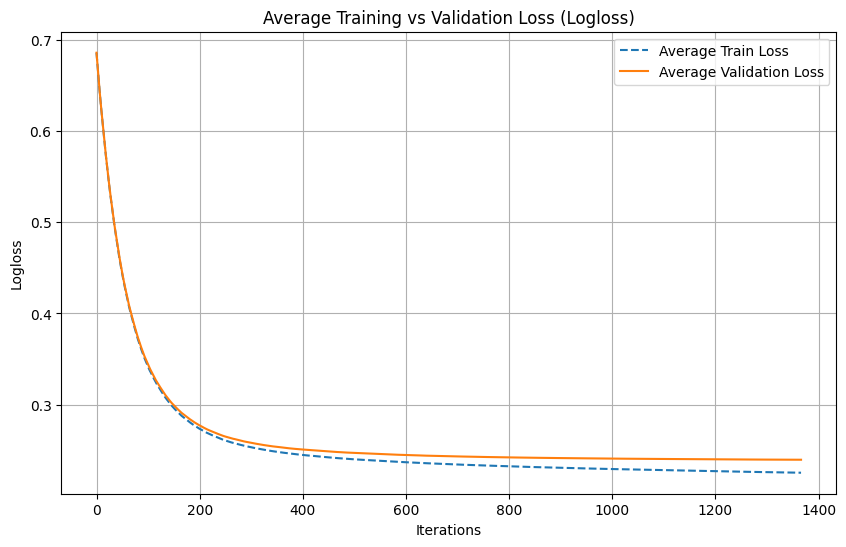

Validation ROC AUC on Hold-out Set: 0.9324


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import numpy as np

# Initialize Stratified K-Fold
n_splits = 5  # Number of folds for cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

# Initialize lists to store fold results
train_auc_scores = []
val_auc_scores = []
train_losses = []
val_losses = []

params = {
    'bagging_temperature': 0.8, 'depth': 6, 'iterations': 1700, 'l2_leaf_reg': 3, 'learning_rate': 0.006,
    'verbose': 0,
    'cat_features': categorical_features, 
    'subsample': 0.9, #added
    'random_strength': 1.0,  # Added
    'max_bin': 254,  # Added
    'min_data_in_leaf': 20,# Added
    'leaf_estimation_iterations': 5,  # Added
    "boosting_type": "Ordered"
}

# Train and validate using Stratified K-Fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_after_selection, y_train)):
    # Split the small train set into folds
    X_train_fold, X_val_fold = X_train_after_selection.iloc[train_idx], X_train_after_selection.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Initialize CatBoost model
    model = CatBoostClassifier(**params)

    # Train on current fold
    model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), early_stopping_rounds=50, verbose=0)

    # Extract loss for plotting
    eval_results = model.get_evals_result()
    train_losses.append(eval_results['learn']['Logloss'])
    val_losses.append(eval_results['validation']['Logloss'])

    # Predict probabilities for training and validation folds
    y_train_pred = model.predict_proba(X_train_fold)[:, 1]
    y_val_pred = model.predict_proba(X_val_fold)[:, 1]

    # Calculate ROC AUC for training and validation folds
    train_auc = roc_auc_score(y_train_fold, y_train_pred)
    val_auc = roc_auc_score(y_val_fold, y_val_pred)

    train_auc_scores.append(train_auc)
    val_auc_scores.append(val_auc)

    print(f"Fold {fold + 1}: Train AUC = {train_auc:.4f}, Validation AUC = {val_auc:.4f}")

# Print Cross-Validation Results
mean_train_auc = np.mean(train_auc_scores)
mean_val_auc = np.mean(val_auc_scores)
std_val_auc = np.std(val_auc_scores)

print(f"\nMean Train AUC: {mean_train_auc:.4f}")
print(f"Mean Validation AUC: {mean_val_auc:.4f}")
print(f"Validation AUC Standard Deviation: {std_val_auc:.4f}")

# Calculate average losses across folds
max_iterations = min(len(train_losses[fold]) for fold in range(n_splits))  # Ensure consistent length
avg_train_loss = np.mean([train_losses[fold][:max_iterations] for fold in range(n_splits)], axis=0)
avg_val_loss = np.mean([val_losses[fold][:max_iterations] for fold in range(n_splits)], axis=0)

# Plot Average Loss Graph
plt.figure(figsize=(10, 6))
plt.plot(range(max_iterations), avg_train_loss, label='Average Train Loss', linestyle='--')
plt.plot(range(max_iterations), avg_val_loss, label='Average Validation Loss')
plt.title('Average Training vs Validation Loss (Logloss)')
plt.xlabel('Iterations')
plt.ylabel('Logloss')
plt.legend()
plt.grid(True)
plt.show()

# Train final model on the entire small train set
final_model = CatBoostClassifier(
   **params
)
final_model.fit(X_train_after_selection, y_train, eval_set=(X_val_after_selection, y_val), early_stopping_rounds=50, verbose=0)

# Evaluate on validation set
y_val_pred = final_model.predict_proba(X_val_after_selection)[:, 1]
final_roc_auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation ROC AUC on Hold-out Set: {final_roc_auc:.4f}")

#0.9315


In [25]:
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import numpy as np

# Initialize Stratified K-Fold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

# Define Hyperopt search space
space = {
    'bagging_temperature': hp.uniform('bagging_temperature', 0.5, 1.0),
    'depth': hp.choice('depth', [4, 6, 8, 10]),
    'iterations': hp.choice('iterations', [1000, 1500, 1700, 2000]),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', np.log(1), np.log(10)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.03)),
    'subsample': hp.uniform('subsample', 0.7, 1.0),
    'random_strength': hp.uniform('random_strength', 0.5, 2.0),
    'max_bin': hp.choice('max_bin', [128, 254, 512]),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 10, 50, 5),
    'leaf_estimation_iterations': hp.choice('leaf_estimation_iterations', [1, 5, 10]),
    'boosting_type': hp.choice('boosting_type', ['Ordered', 'Plain']),
}

# Define the objective function
def objective(params):
    # Convert some parameters to integers
    params['depth'] = int(params['depth'])
    params['iterations'] = int(params['iterations'])
    params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
    params['leaf_estimation_iterations'] = int(params['leaf_estimation_iterations'])
    
    # Add fixed categorical features
    params['cat_features'] = categorical_features
    params['verbose'] = 0

    val_auc_scores = []

    # Perform cross-validation
    for train_idx, val_idx in skf.split(X_train_after_selection, y_train):
        X_train_fold, X_val_fold = X_train_after_selection.iloc[train_idx], X_train_after_selection.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train CatBoost model
        model = CatBoostClassifier(**params)
        model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), early_stopping_rounds=50)

        # Calculate validation AUC
        y_val_pred = model.predict_proba(X_val_fold)[:, 1]
        val_auc = roc_auc_score(y_val_fold, y_val_pred)
        val_auc_scores.append(val_auc)

    # Return the negative mean AUC (Hyperopt minimizes the objective function)
    return {'loss': -np.mean(val_auc_scores), 'status': STATUS_OK}

# Run Hyperopt
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,  # Number of parameter combinations to evaluate
    trials=trials
)

# Decode the best hyperparameters
best_params = {
    'depth': [4, 6, 8, 10][best['depth']],
    'iterations': [1000, 1500, 1700, 2000][best['iterations']],
    'max_bin': [128, 254, 512][best['max_bin']],
    'leaf_estimation_iterations': [1, 5, 10][best['leaf_estimation_iterations']],
    'boosting_type': ['Ordered', 'Plain'][best['boosting_type']],
    **{key: best[key] for key in best if key not in ['depth', 'iterations', 'max_bin', 'leaf_estimation_iterations', 'boosting_type']}
}

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)


100%|██████████| 50/50 [1:14:44<00:00, 89.70s/trial, best loss: -0.9381021530034757] 
Best Hyperparameters: {'depth': 6, 'iterations': 1500, 'max_bin': 512, 'leaf_estimation_iterations': 5, 'boosting_type': 'Ordered', 'bagging_temperature': 0.64555231719653, 'l2_leaf_reg': 2.4285635418576725, 'learning_rate': 0.021204080763231766, 'min_data_in_leaf': 15.0, 'random_strength': 1.2818878521708486, 'subsample': 0.7001762182139037}


Fold 1: Train AUC = 0.9484, Validation AUC = 0.9296
Fold 2: Train AUC = 0.9483, Validation AUC = 0.9288
Fold 3: Train AUC = 0.9445, Validation AUC = 0.9506
Fold 4: Train AUC = 0.9449, Validation AUC = 0.9482
Fold 5: Train AUC = 0.9471, Validation AUC = 0.9321

Mean Train AUC: 0.9466
Mean Validation AUC: 0.9379
Validation AUC Standard Deviation: 0.0095


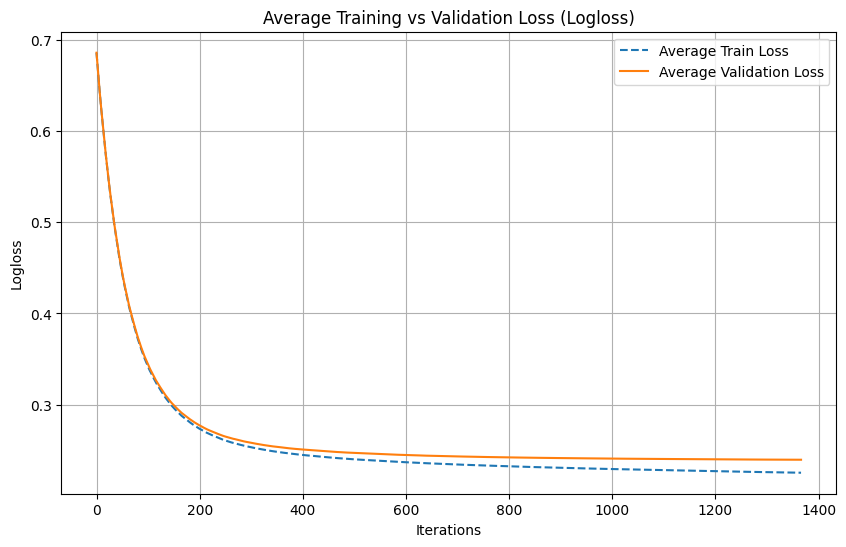

Validation ROC AUC on Hold-out Set: 0.9324


In [24]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import numpy as np

# Initialize Stratified K-Fold
n_splits = 5  # Number of folds for cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

# Initialize lists to store fold results
train_auc_scores = []
val_auc_scores = []
train_losses = []
val_losses = []

params = {
    'bagging_temperature': 0.8, 'depth': 6, 'iterations': 1700, 'l2_leaf_reg': 3, 'learning_rate': 0.006,
    'verbose': 0,
    'cat_features': categorical_features, 
    'subsample': 0.9, #added
    'random_strength': 1.0,  # Added
    'max_bin': 254,  # Added
    'min_data_in_leaf': 20,# Added
    'leaf_estimation_iterations': 5,  # Added
    "boosting_type": "Ordered"
}

# Train and validate using Stratified K-Fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_after_selection, y_train)):
    # Split the small train set into folds
    X_train_fold, X_val_fold = X_train_after_selection.iloc[train_idx], X_train_after_selection.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Initialize CatBoost model
    model = CatBoostClassifier(**params)

    # Train on current fold
    model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), early_stopping_rounds=50, verbose=2)

    # Extract loss for plotting
    eval_results = model.get_evals_result()
    train_losses.append(eval_results['learn']['Logloss'])
    val_losses.append(eval_results['validation']['Logloss'])

    # Predict probabilities for training and validation folds
    y_train_pred = model.predict_proba(X_train_fold)[:, 1]
    y_val_pred = model.predict_proba(X_val_fold)[:, 1]

    # Calculate ROC AUC for training and validation folds
    train_auc = roc_auc_score(y_train_fold, y_train_pred)
    val_auc = roc_auc_score(y_val_fold, y_val_pred)

    train_auc_scores.append(train_auc)
    val_auc_scores.append(val_auc)

    print(f"Fold {fold + 1}: Train AUC = {train_auc:.4f}, Validation AUC = {val_auc:.4f}")

# Print Cross-Validation Results
mean_train_auc = np.mean(train_auc_scores)
mean_val_auc = np.mean(val_auc_scores)
std_val_auc = np.std(val_auc_scores)

print(f"\nMean Train AUC: {mean_train_auc:.4f}")
print(f"Mean Validation AUC: {mean_val_auc:.4f}")
print(f"Validation AUC Standard Deviation: {std_val_auc:.4f}")

# Calculate average losses across folds
max_iterations = min(len(train_losses[fold]) for fold in range(n_splits))  # Ensure consistent length
avg_train_loss = np.mean([train_losses[fold][:max_iterations] for fold in range(n_splits)], axis=0)
avg_val_loss = np.mean([val_losses[fold][:max_iterations] for fold in range(n_splits)], axis=0)

# Plot Average Loss Graph
plt.figure(figsize=(10, 6))
plt.plot(range(max_iterations), avg_train_loss, label='Average Train Loss', linestyle='--')
plt.plot(range(max_iterations), avg_val_loss, label='Average Validation Loss')
plt.title('Average Training vs Validation Loss (Logloss)')
plt.xlabel('Iterations')
plt.ylabel('Logloss')
plt.legend()
plt.grid(True)
plt.show()

# Train final model on the entire small train set
final_model = CatBoostClassifier(
   **params
)
final_model.fit(X_train_after_selection, y_train, eval_set=(X_val_after_selection, y_val), early_stopping_rounds=50, verbose=0)

# Evaluate on validation set
y_val_pred = final_model.predict_proba(X_val_after_selection)[:, 1]
final_roc_auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation ROC AUC on Hold-out Set: {final_roc_auc:.4f}")



In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
import numpy as np

space = {
    'max_bin': hp.choice('max_bin', [128, 254, 512]),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 10, 100, 10),
    'leaf_estimation_iterations': hp.choice('leaf_estimation_iterations', [5, 10, 20]),
}

# Initialize Stratified K-Fold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

# Define the objective function for Hyperopt
def objective(params):
    params['max_bin'] = int(params['max_bin'])
    params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
    params['leaf_estimation_iterations'] = int(params['leaf_estimation_iterations'])
    params['cat_features'] = categorical_features  # Include categorical features
    params['verbose'] = 0  # Disable verbose output for folds
    params['bagging_temperature'] = 0.8,
    params['depth'] = 6 ,
    params['iterations'] = 1700 ,
    params['l2_leaf_reg'] = 3 ,
    params['learning_rate'] = 0.006 ,
    params['subsample'] = 0.9, 
    params['random_strength'] = 1.0 ,
    params['boosting_type'] = "Ordered"

    train_auc_scores = []
    val_auc_scores = []

    for train_idx, val_idx in skf.split(X_train_after_selection, y_train):
        # Split the data for this fold
        X_train_fold, X_val_fold = X_train_after_selection.iloc[train_idx], X_train_after_selection.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Initialize and train the CatBoost model
        model = CatBoostClassifier(**params)
        model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), early_stopping_rounds=50)

        # Predict probabilities for validation set
        y_val_pred = model.predict_proba(X_val_fold)[:, 1]
        val_auc = roc_auc_score(y_val_fold, y_val_pred)

        # Store the validation AUC
        val_auc_scores.append(val_auc)

    # Return the negative mean validation AUC as the loss
    mean_val_auc = np.mean(val_auc_scores)
    return {'loss': -mean_val_auc, 'status': STATUS_OK}

# Run Hyperopt
trials = Trials()
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,  # Number of iterations to run
    trials=trials,
    rstate=np.random.default_rng(42)  # For reproducibility
)

# Decode the best parameters
decoded_params = {
    'max_bin': [128, 254, 512][best_params['max_bin']],
    'leaf_estimation_iterations': [1, 5, 10][best_params['leaf_estimation_iterations']],
    'boosting_type': ['Ordered', 'Plain'][best_params['boosting_type']],
    **{key: best_params[key] for key in best_params if key not in ['max_bin', 'leaf_estimation_iterations', 'boosting_type']}
}

print("Best Parameters:", decoded_params)

# Train final model with best parameters
final_model = CatBoostClassifier(**decoded_params, cat_features=categorical_features, verbose=100)
final_model.fit(X_train_after_selection, y_train, eval_set=(X_val_after_selection, y_val), early_stopping_rounds=50)

# Evaluate on validation set
y_val_pred = final_model.predict_proba(X_val_after_selection)[:, 1]
final_roc_auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation ROC AUC on Hold-out Set: {final_roc_auc:.4f}")


In [23]:
y_pred_proba_best = final_model.predict_proba(X_test)[:, 1]

# Créez sample_submission avec 'id' et 'Churn_Probability'
sample_submission_test_N = data_test[['id']].copy()  # Copie uniquement la colonne 'id' de data_test
sample_submission_test_N["Exited"] = y_pred_proba_best  # Ajout des probabilités de churn

# Optionnel : Exportez sample_submission en CSV
sample_submission_test_N.to_csv("results.csv", index=False)
